In [31]:
import gzip
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import Functions

In [32]:


with gzip.open('cleaned_data.zip','rb') as file:
    feature_data = pd.read_csv(file,index_col=[0,1])

with gzip.open('new_label_data.zip','rb') as file:
    new_label_data = pd.read_csv(file,index_col=[0,1])

data = pd.concat([feature_data,new_label_data],join='inner',ignore_index=False,axis=1)





In [33]:
print(feature_data.shape)
print(new_label_data.value_counts())

(334047, 50)
Status
0         76282
6         59461
4         54441
1         52496
2         21894
3         17090
5          9891
dtype: int64


In [53]:
X = data.iloc[:,:-1].values
Y = data.iloc[:,-1].values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size= 0.1,random_state=16,shuffle=True)

X_train = tf.reshape(X_train,(-1,5,10))
X_test = tf.reshape(X_test,(-1,5,10))


In [67]:

# Each MNIST image batch is a tensor of shape (batch_size, 28, 28).
# Each input sequence will be of size (28, 28) (height is treated like time).
input_dim = 10
batch_size = int(len(X_train)//10000)
units = 128
output_size = 7  # labels are from 0 to 6

# Build the RNN model
def build_model():
    lstm_layer = keras.layers.LSTM(units, input_shape=(None,input_dim))
    model = keras.models.Sequential(
        [
            lstm_layer,
            keras.layers.Dropout(0.5),
            keras.layers.BatchNormalization(),
            keras.layers.Dense(128, activation='relu'),
            keras.layers.Dense(output_size, activation='softmax'),
        ]
    )
    return model

In [68]:
model = build_model()
#model.summary()
model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(),
    optimizer="Adam",
    metrics=["accuracy"]
)
LSTM_model = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), batch_size=batch_size, epochs=2)


Epoch 1/2
 7863/10093 [======================>.......] - ETA: 13s - loss: 1.4413 - accuracy: 0.4526

KeyboardInterrupt: 

In [ ]:
for uuid in data.groupby('uuid').count().index:

    X = data.loc[uuid].iloc[:,:-1].values
    Y = data.loc[uuid].iloc[:,-1].values
    X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size= 0.05,random_state=6,shuffle=False)
    X_train = tf.reshape(X_train,(-1,10,5))

    batch_size = int(len(X_train)//1000)
    LSTM_model = model.fit(X_train, Y_train, validation_data=(X_test_list, Y_test_list), batch_size=batch_size, epochs=1)



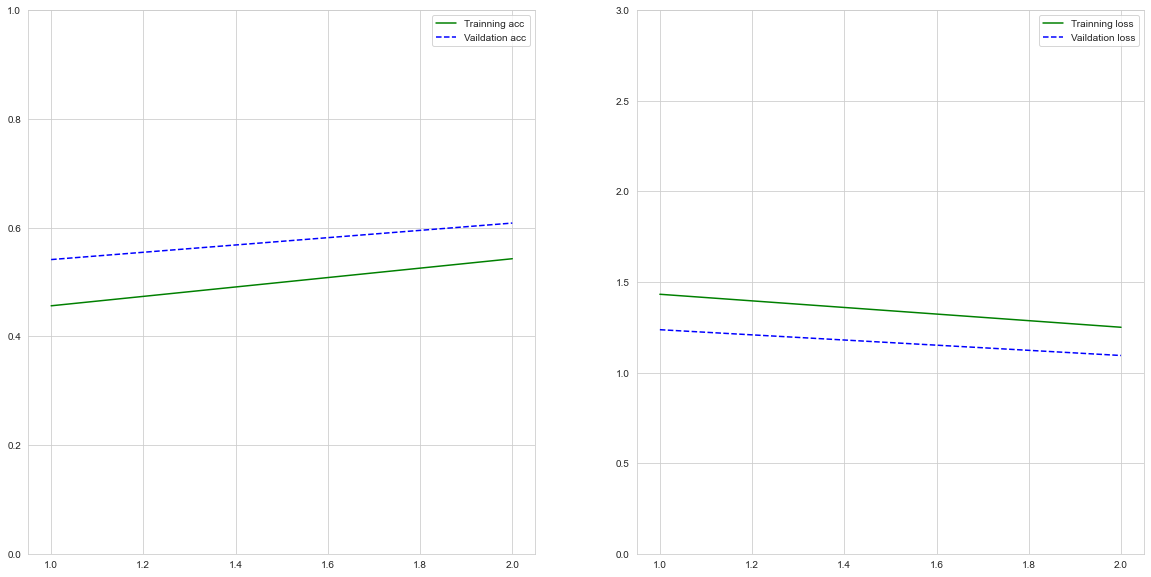

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns  
sns.set_style("whitegrid") 


acc = LSTM_model.history['accuracy']     #获取训练集准确性数据
val_acc = LSTM_model.history['val_accuracy']    #获取验证集准确性数据
loss = LSTM_model.history['loss']          #获取训练集错误值数据
val_loss = LSTM_model.history['val_loss']  #获取验证集错误值数据

epochs = range(1,len(acc)+1)
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(121)
ax1.plot(epochs,acc,'g',label='Trainning acc')     #以epochs为横坐标，以训练集准确性为纵坐标
ax1.plot(epochs,val_acc,'b--',label='Vaildation acc') #以epochs为横坐标，以验证集准确性为纵坐标
ax1.legend()   #绘制图例，即标明图中的线段代表何种含义
plt.ylim(0,1)
ax2 = fig.add_subplot(122)
ax2.plot(epochs,loss,'g',label='Trainning loss')
ax2.plot(epochs,val_loss,'b--',label='Vaildation loss')
ax2.legend()  ##绘制图例，即标明图中的线段代表何种含义
plt.ylim(0,3)
plt.show()


In [75]:
predictions = model.predict(X_test)

y_test_pred = np.argmax(predictions, axis=1)

912/912 [==============================] - 2s 2ms/step


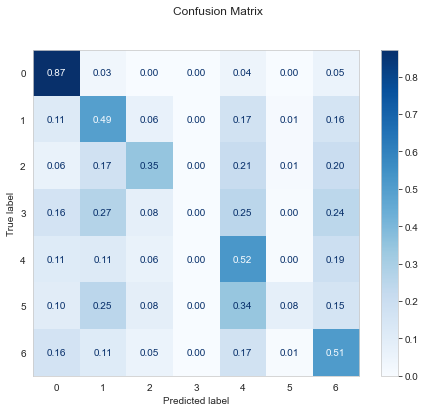

In [76]:
from sklearn import metrics

confusion = metrics.ConfusionMatrixDisplay.from_predictions(Y_test,y_test_pred,cmap='Blues',normalize='true',values_format='.2f')
confusion.figure_.suptitle("Confusion Matrix")
confusion.figure_.set_size_inches(8,6)
plt.grid(visible=None)
plt.show()